# Basic Graph Analysis


Graphs are described using basic and graph theoretical measures. Distribution of measures across the dataset are plotted.



In [2]:
import warnings
warnings.filterwarnings("ignore")
import glob
import os
import os.path as op
import sys
sys.path.append(
    '/Users/CN/Documents/Projects/Cambridge/cambridge_language_analysis/')

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Data Processing
import numpy as np
import pandas as pd
import datetime
import re
# import gensim
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import networkx as nx

# Statistics
import scipy

# SemanticSpeechGraph functions
from compile_graphs_dataset import get_graphs, graph_properties, exclude_empty_graphs
from graph_analysis_functions import print_bidirectional_edges, print_parallel_edges, get_parallel_edges
from word_embedding_analysis import central_words

In [3]:
# --------------------- Import graphs ---------------------------------------
graph_dir = '/Users/CN/Dropbox/speech_graphs/oasis'
output_figures = op.join(graph_dir, 'figures')

graphs, filelist = get_graphs(graph_dir)
graphs, filelist = exclude_empty_graphs(graphs, filelist, be_quiet=True)

# --------------------- Import graph data ---------------------------------------
df = pd.read_csv(op.join(graph_dir, 'output/graph_data.csv'))
print('Described {0} graphs.\n{1} subjects described {2} ± {3} pictures.'.format(df.shape[0], len(df.subj.unique()), round(df.subj.value_counts().mean(),2), round(df.subj.value_counts().std(),2)))


# Make subj and tat categorical
df.subj = pd.Categorical(df.subj.astype('str'))
df.tat = pd.Categorical(df.tat.astype('str'))


id_data = pd.read_csv('/Users/CN/Documents/Projects/Cambridge/data/oasis/ids_oasis.csv', delimiter=';')
df['group'] = np.nan
for s, subj in enumerate(id_data.Subject):
    df.at[df.subj == str(subj), 'group'] = id_data.Group[s]

df.group = pd.Categorical(df.group.astype('str'))
df.group = df.group.cat.rename_categories({'ARMS': 'CHR'})

df.group = df.group.cat.reorder_categories(
    ['CON', 'CHR', 'FEP'])


print('--- Groups ---\n{}'.format(df.group.value_counts()))

Obtained 423 graphs. Excluded 0 empty graphs. Kept 423 graphs.
Described 423 graphs.
53 subjects described 7.98 ± 0.14 pictures.
--- Groups ---
CHR    191
FEP    128
CON    104
Name: group, dtype: int64


In [4]:
# Exclude subject 12 because of bad quality transcripts
df.shape
df = df[df.subj.values != '12']
graphs = [graphs[i] for i in df.index.tolist()]


In [49]:
# Calculate additional measures
df['inverse_nodes'] = 1/df.nodes
df['max_degree_centrality_abs'] = df.max_degree_centrality*(df.nodes-1)
df['max_indegree_centrality_abs'] = df.max_indegree_centrality_value*df.nodes
df['max_outdegree_centrality_abs'] = df.max_outdegree_centrality_value*df.nodes
df['nodes_over_words'] = df.nodes/df.words


In [50]:
# --------------------- Average across TAT stimuli ( = one datapoint per participant ) ---------------------------------------
df['group_n'] = None
df.group_n = df.group.cat.codes*100
oasis_avg = (df.groupby((df.subj != df.subj.shift()).cumsum())
                  .mean()
                  .reset_index(drop=True))

# oasis_avg.group_n.value_counts()
# oasis_avg['group'] = oasis_avg.group_n.astype("category")
oasis_avg['group'] = pd.Categorical(oasis_avg.group_n)

oasis_avg.group = oasis_avg.group.cat.rename_categories({0: 'CON', -56: 'FEP', 100: 'CHR'})
oasis_avg.group.cat.reorder_categories(
    ['CON', 'CHR', 'FEP'], inplace=True)

print('--- Groups ---\n{}'.format(oasis_avg.group.value_counts()))

--- Groups ---
CHR    24
FEP    16
CON    12
Name: group, dtype: int64


# Plots

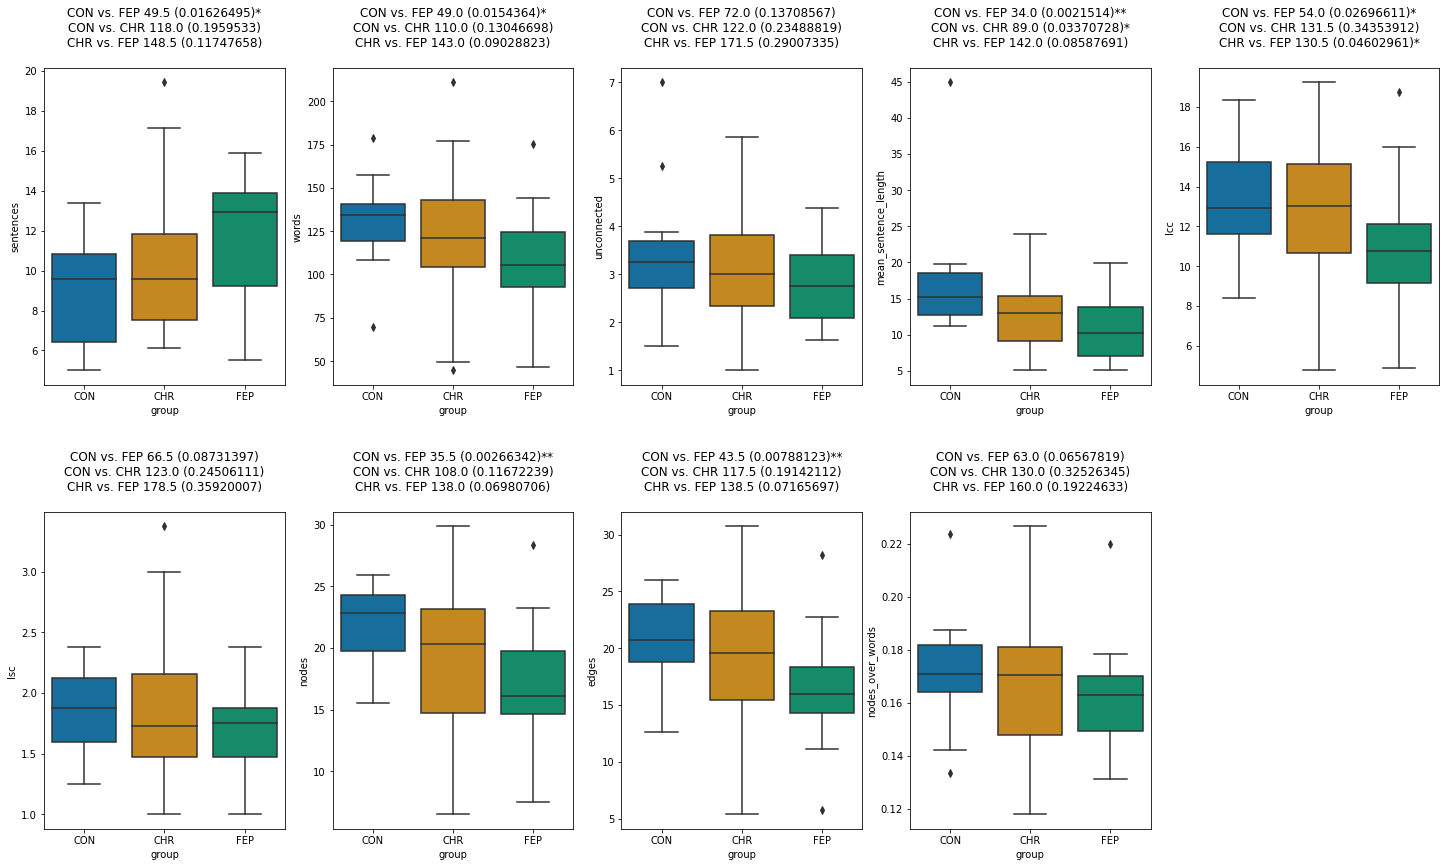

In [41]:
# ----------- boxplot for each group: Sentences, Words, Unconnected Nodes, Average Total Degree, LCC, LSC, Nodes, Edges, 

variable_list = ['sentences', 'words', 'unconnected', 'mean_sentence_length', 'lcc', 'lsc', 'nodes', 'edges','nodes_over_words']
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(2, np.ceil(len(variable_list)/2), v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis_avg,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis_avg.query('group == @comb[0]')[variable]
        b = oasis_avg.query('group == @comb[1]')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

sentences ShapiroResult(statistic=0.966036856174469, pvalue=0.14295326173305511)
words ShapiroResult(statistic=0.9846726655960083, pvalue=0.7368231415748596)
unconnected ShapiroResult(statistic=0.9416887164115906, pvalue=0.01312354113906622)
mean_sentence_length ShapiroResult(statistic=0.8013538122177124, pvalue=6.407344130821002e-07)
lcc ShapiroResult(statistic=0.9821994304656982, pvalue=0.6231693029403687)
lsc ShapiroResult(statistic=0.9438952207565308, pvalue=0.01617412269115448)
nodes ShapiroResult(statistic=0.9834076166152954, pvalue=0.6786981225013733)
edges ShapiroResult(statistic=0.9859191179275513, pvalue=0.7924327254295349)


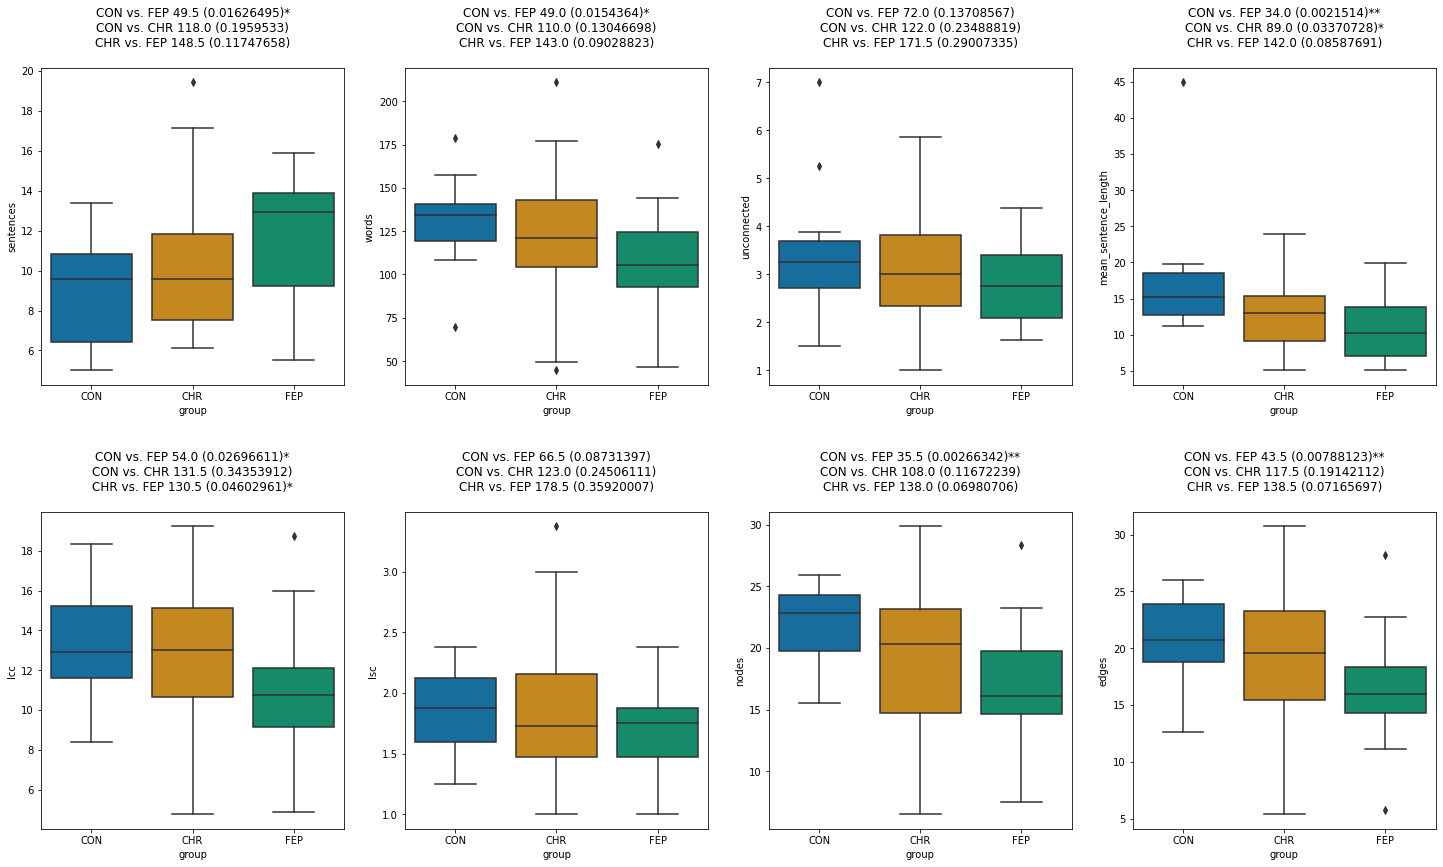

In [42]:
# ----------- boxplot for each group: Sentences, Words, Unconnected Nodes, Average Total Degree, LCC, LSC, Nodes, Edges, 
variable_list = ['sentences', 'words', 'unconnected', 'mean_sentence_length', 'lcc', 'lsc', 'nodes', 'edges']
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(2, np.ceil(len(variable_list)/2), v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis_avg,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    print(variable, scipy.stats.shapiro(oasis_avg[variable]))
    for c, comb in enumerate(group_comparisons):
        a = oasis_avg.query('group == @comb[0]')[variable]
        b = oasis_avg.query('group == @comb[1]')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

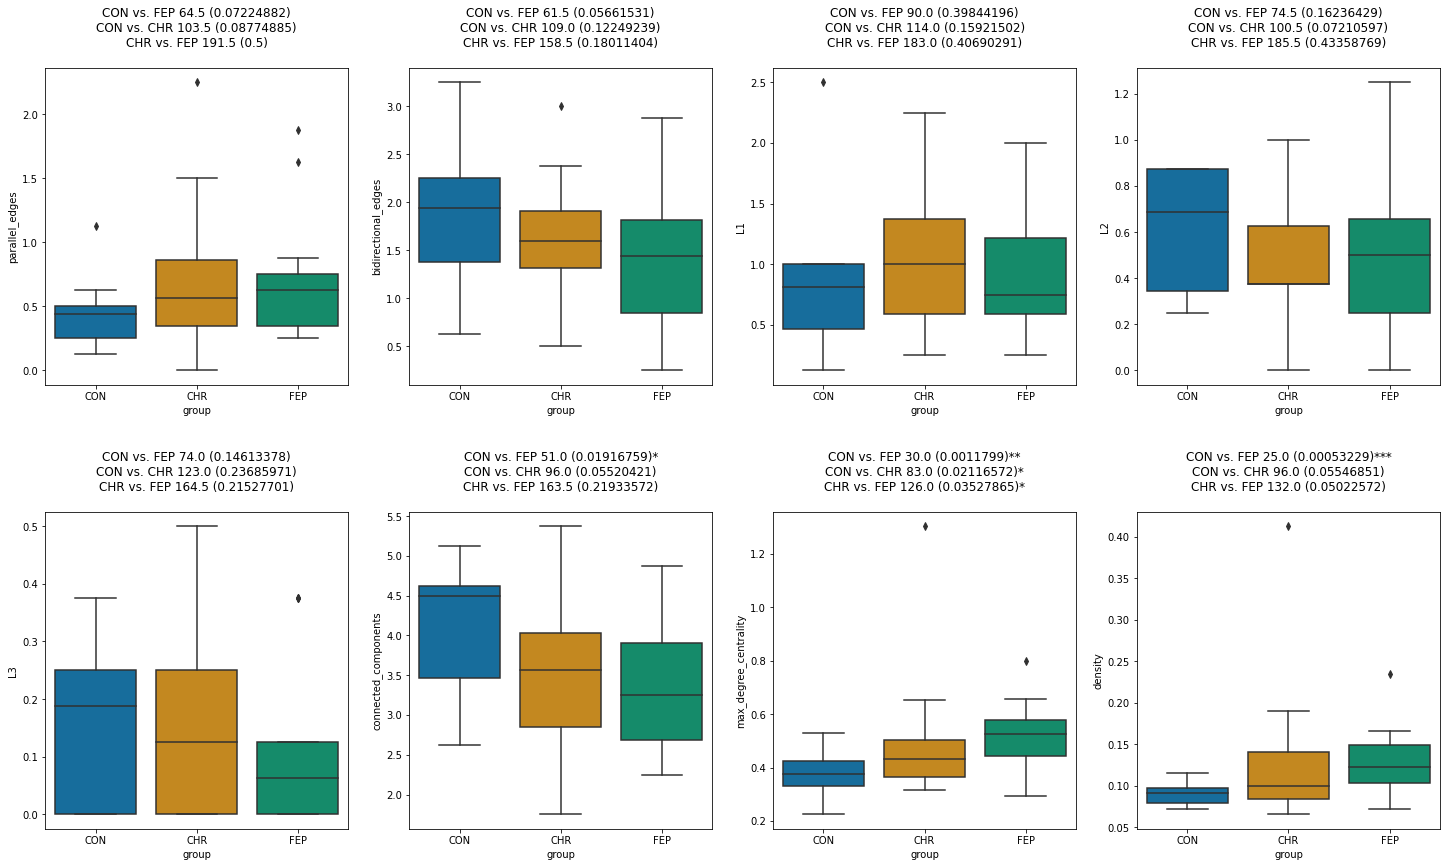

In [43]:
# ----------- boxplot for each group: Sentences, Words, Unconnected Nodes, Average Total Degree, LCC, LSC, Nodes, Edges, 
# variable_list = ['sentences', 'words', 'unconnected', 'average_total_degree', 'lcc', 'lsc', 'nodes', 'edges']
variable_list = [ 'parallel_edges', 'bidirectional_edges', 'L1', 'L2', 'L3', 'connected_components', 'max_degree_centrality', 'density']



group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(2, np.ceil(len(variable_list)/2), v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis_avg,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    # print(variable, scipy.stats.shapiro(oasis_avg[variable]))
    for c, comb in enumerate(group_comparisons):
        a = oasis_avg.query('group == @comb[0]')[variable]
        b = oasis_avg.query('group == @comb[1]')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)



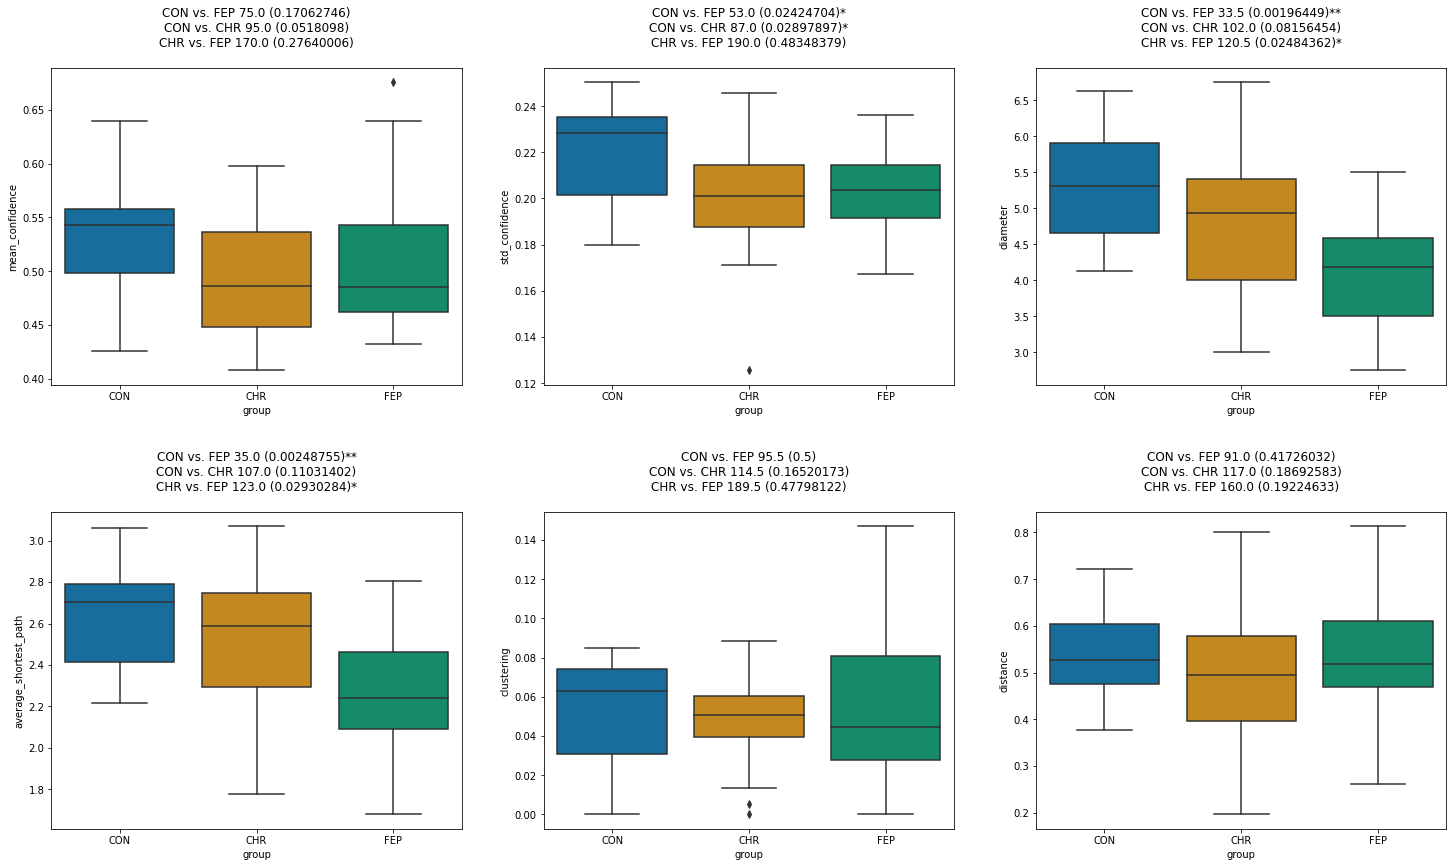

In [44]:
variable_list = ['mean_confidence', 'std_confidence',  'diameter', 'average_shortest_path', 'clustering', 'distance']


group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(2, np.ceil(len(variable_list)/2), v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis_avg,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis_avg.query('group == @comb[0]')[variable]
        b = oasis_avg.query('group == @comb[1]')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)




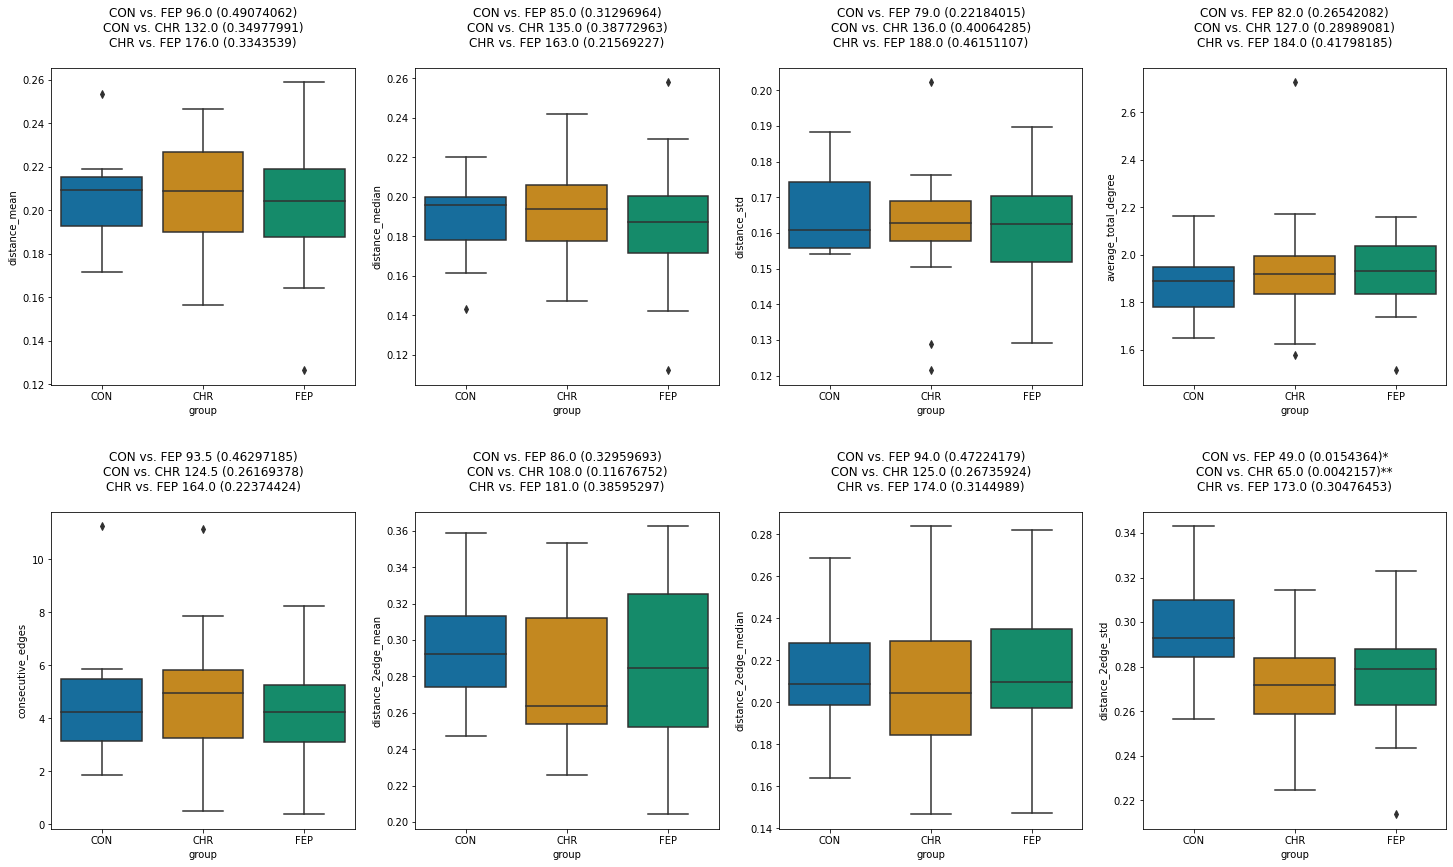

In [45]:
variable_list = ['distance_mean', 'distance_median', 'distance_std', 'average_total_degree', 'consecutive_edges', 'distance_2edge_mean','distance_2edge_median','distance_2edge_std']
# variable_list = [ 'average_total_degree', 'consecutive_edges']

group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(2, np.ceil(len(variable_list)/2), v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis_avg,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis_avg.query('group == @comb[0]')[variable]
        b = oasis_avg.query('group == @comb[1]')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)



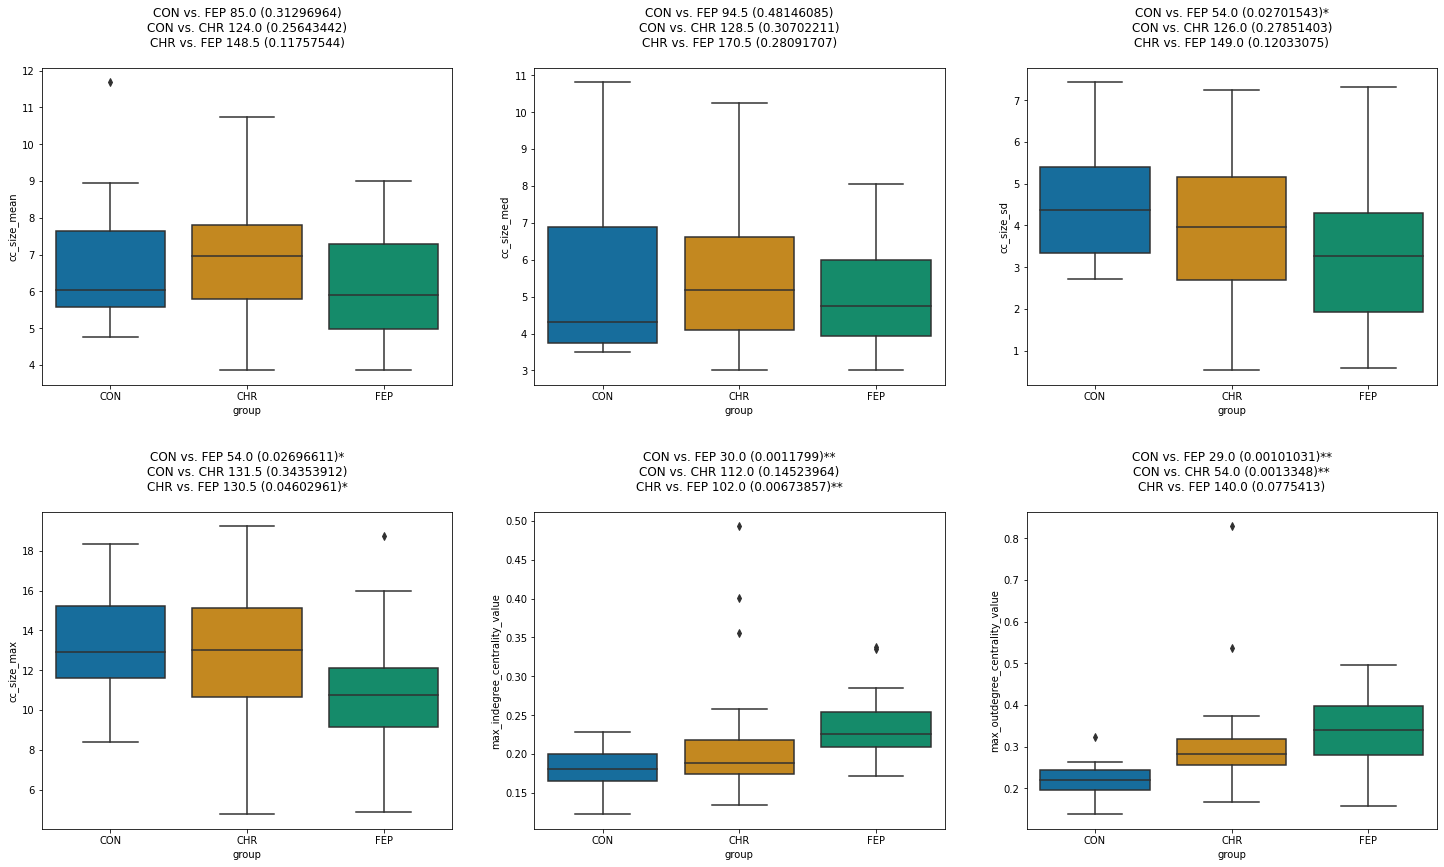

In [46]:
variable_list = ['cc_size_mean','cc_size_med','cc_size_sd','cc_size_max', 'max_indegree_centrality_value','max_outdegree_centrality_value']
oasis_avg = oasis_avg

group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(2, np.ceil(len(variable_list)/2), v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis_avg,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis_avg.query('group == @comb[0]')[variable]
        b = oasis_avg.query('group == @comb[1]')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)




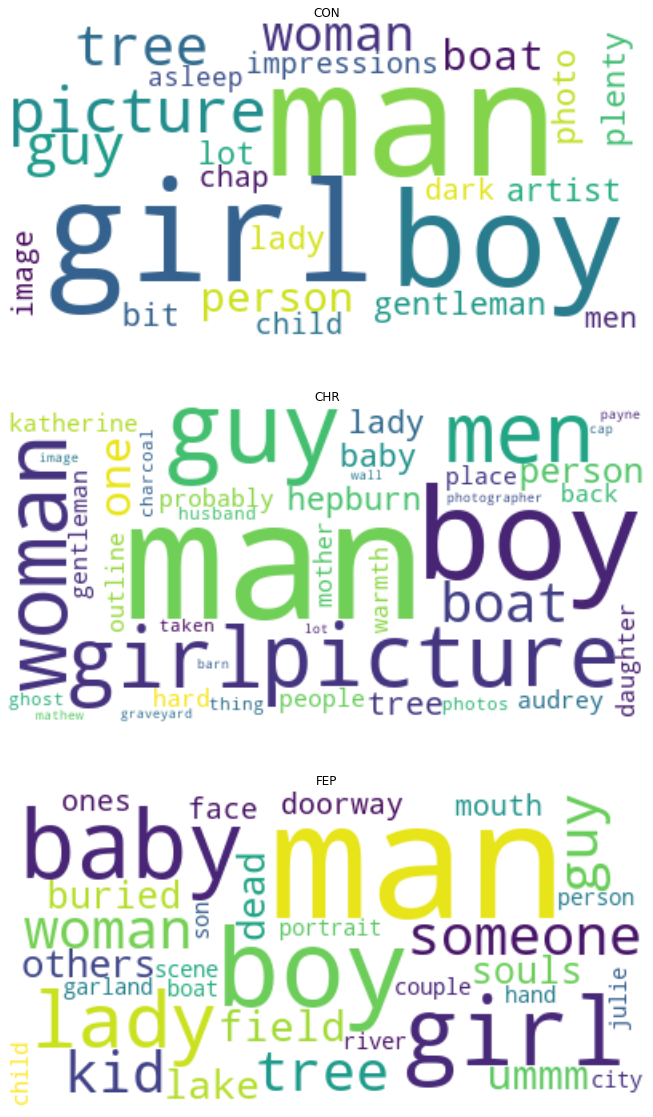

In [70]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

fig = plt.figure(figsize=(25,20))
for c, comb in enumerate(['CON', 'CHR', 'FEP']):
    ax = plt.subplot(3, 1, c+1)
    text = ' '.join(df.query('group == @comb')['max_degree_node'].values)
    # print(df.query('group == @comb')['max_degree_node'])
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(comb)

plt.subplots_adjust(hspace = 0.2)
output = op.join(output_figures, 'WordCloud_CentralNode' +
                 '_{}'.format(str(datetime.date.today())))
plt.savefig(output)

plt.show()
# df.max_degree_node

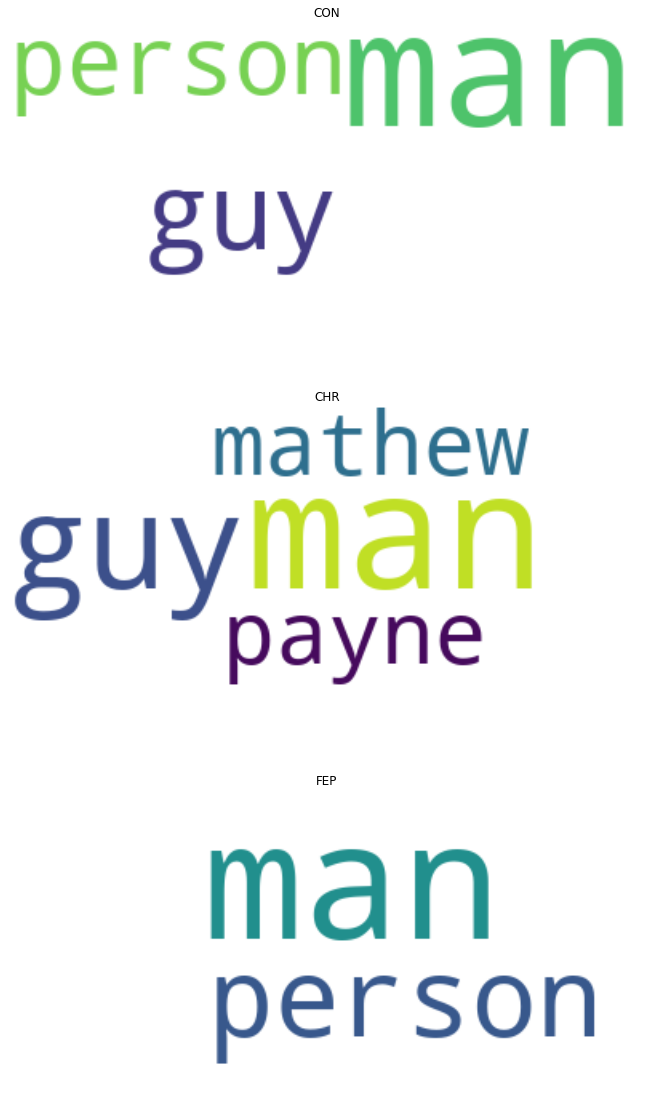

In [71]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

fig = plt.figure(figsize=(25,20))
for c, comb in enumerate(['CON', 'CHR', 'FEP']):
    ax = plt.subplot(3, 1, c+1)
    text = ' '.join(df.query('group == @comb & tat == "3"')['max_degree_node'].values)
    # print(df.query('group == @comb')['max_degree_node'])
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(comb)

plt.subplots_adjust(hspace = 0.2)
output = op.join(output_figures, 'WordCloud_TAT3' +
                 '_{}'.format(str(datetime.date.today())))
plt.savefig(output)

plt.show()
# df.max_degree_node

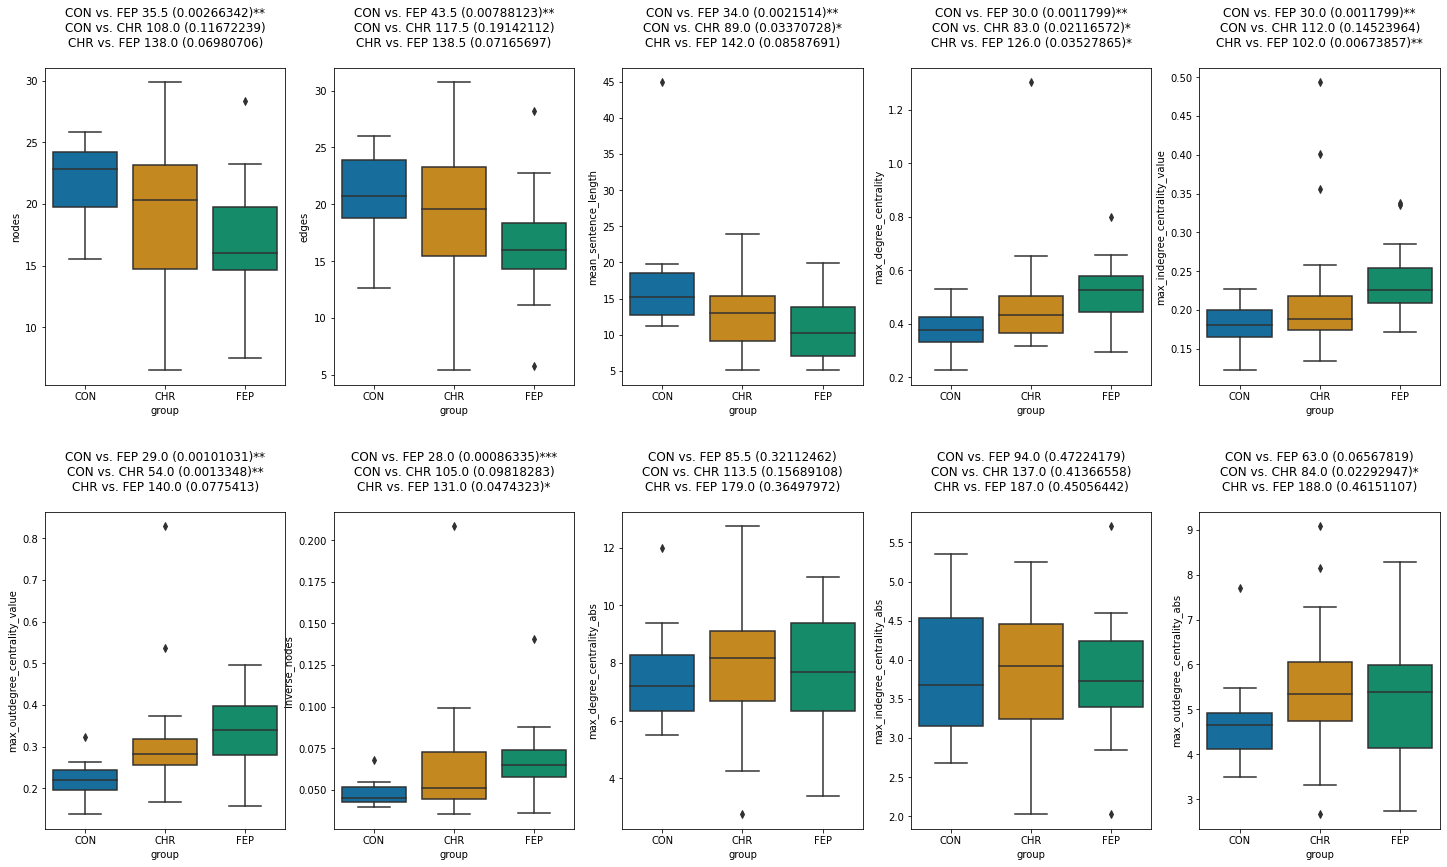

In [51]:

# variable_list = ['nodes','edges','mean_sentence_length','max_degree_centrality', 'max_indegree_centrality_value','max_outdegree_centrality_value', 'max_degree_centrality_abs']

# variable_list = ['nodes','edges','mean_sentence_length','max_degree_centrality', 'max_indegree_centrality_value','max_outdegree_centrality_value', 'max_degree_centrality_abs', 'max_indegree_centrality_value_abs','max_outdegree_centrality_value_abs']
variable_list = ['nodes','edges','mean_sentence_length','max_degree_centrality', 'max_indegree_centrality_value','max_outdegree_centrality_value', 'inverse_nodes', 'max_degree_centrality_abs', 'max_indegree_centrality_abs', 'max_outdegree_centrality_abs']

group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(2, np.ceil(len(variable_list)/2), v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis_avg,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis_avg.query('group == @comb[1]')[variable]
        b = oasis_avg.query('group == @comb[1]')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)



In [ ]:


variable = 'nodes'
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for t,tat in enumerate(df.tat.cat.categories):
    ax = plt.subplot(2, np.ceil(len(df.tat.cat.categories)/2), t+1)
    sns.boxplot(y=variable, x='group',
              data=df.query('tat == @tat'),
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = 'TAT {}\n'.format(tat)
    for c, comb in enumerate(group_comparisons):
        a = df.query('group == @comb[0] & tat == @tat')[variable]
        b = df.query('group == @comb[1] & tat == @tat')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_Nodes-TATwise' +
                 '_{}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

In [76]:
df_tat3 = df.query('tat == "3"')
df_tat3.sort_values(by=['group', 'subj'], ascending=[True, True], inplace=True, ignore_index=True)

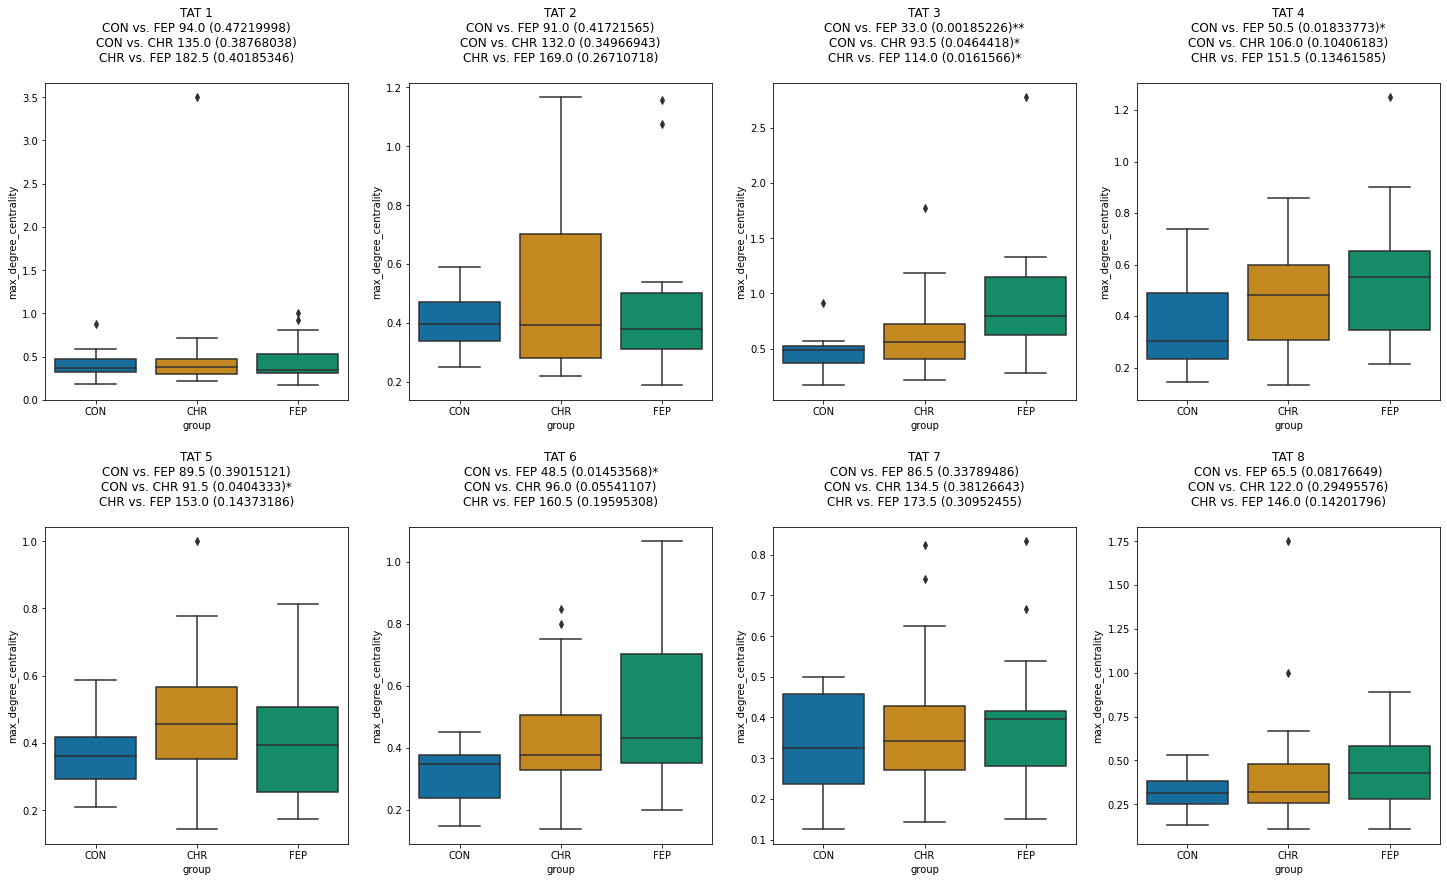

In [48]:


variable = 'max_degree_centrality'
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(25, 14))
for t,tat in enumerate(df.tat.cat.categories):
    ax = plt.subplot(2, np.ceil(len(df.tat.cat.categories)/2), t+1)
    sns.boxplot(y=variable, x='group',
              data=df.query('tat == @tat'),
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = 'TAT {}\n'.format(tat)
    for c, comb in enumerate(group_comparisons):
        a = df.query('group == @comb[0] & tat == @tat')[variable]
        b = df.query('group == @comb[1] & tat == @tat')[variable]
        results_mwu.append(scipy.stats.mannwhitneyu(a,b))
        results_ttest.append(scipy.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures, 'Hist_TATwise' +
                 '_{}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)

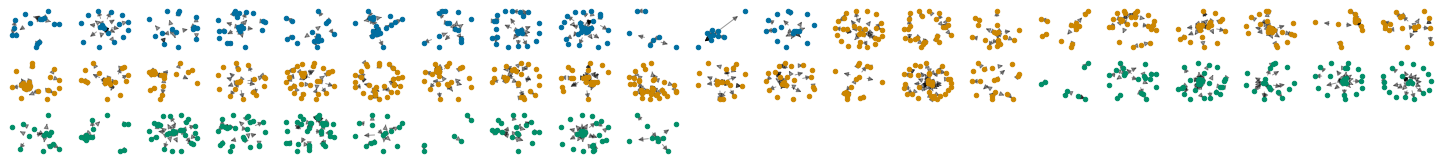

In [39]:
df_sorted = df
df_sorted['graph'] = graphs
df_sorted.sort_values(by=['group', 'subj'], ascending=[True, True], inplace=True, ignore_index=True)
df_sorted = df_sorted.query('tat == "3"').reset_index()
# --------------------- Raster Plot of all Graphs - with Groups colored ---------------------------------------
fig = plt.figure(figsize=(25.6, 20))
for g, G in enumerate(df_sorted.graph):
    ax = plt.subplot(np.ceil(np.sqrt(len(graphs))), np.ceil(np.sqrt(len(graphs))), g + 1)
    pos = nx.spring_layout(G)
    plt.axis("off")
    if df_sorted.group[g] == 'CHR':
        c='#CC8601'
    elif df_sorted.group[g] == 'FEP':
        c='#008E68'
    elif df_sorted.group[g] == 'CON':
        c='#006EA0'
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color=c)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

# --- Optional: Save plot --- 
output = op.join(output_figures, 'GraphsRaster_ColoredPatients' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show()

In [38]:
variable_list = oasis_avg.columns[1:-2]
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]
for variable in variable_list:
    print('\n---- {} ----'.format(variable))
    print(scipy.stats.shapiro(oasis_avg[variable]))
    print('\n')
    # for comb in group_comparisons:
    #     print(comb)
    #     # T-test
    #     a = oasis_avg.query('group == @comb[0]')[variable]
    #     b = oasis_avg.query('group == @comb[1]')[variable]
    #     print('{}'.format(scipy.stats.ttest_ind(a,b)))
    #     print(scipy.stats.mannwhitneyu(a,b))
    #     print('\n')


---- words ----
ShapiroResult(statistic=0.9832251071929932, pvalue=0.6587012410163879)



---- sentences ----
ShapiroResult(statistic=0.9790232181549072, pvalue=0.47232407331466675)



---- nodes ----
ShapiroResult(statistic=0.9809175729751587, pvalue=0.5529492497444153)



---- edges ----
ShapiroResult(statistic=0.9803574681282043, pvalue=0.528383731842041)



---- unconnected ----
ShapiroResult(statistic=0.9463760256767273, pvalue=0.01885732263326645)



---- average_total_degree ----
ShapiroResult(statistic=0.9225195050239563, pvalue=0.0020816985052078962)



---- parallel_edges ----
ShapiroResult(statistic=0.854653000831604, pvalue=1.2670234355027787e-05)



---- bidirectional_edges ----
ShapiroResult(statistic=0.9744037389755249, pvalue=0.31017813086509705)



---- lsc ----
ShapiroResult(statistic=0.9460824728012085, pvalue=0.018325775861740112)



---- lcc ----
ShapiroResult(statistic=0.9783183336257935, pvalue=0.44426918029785156)



---- L1 ----
ShapiroResult(statistic=0.92434

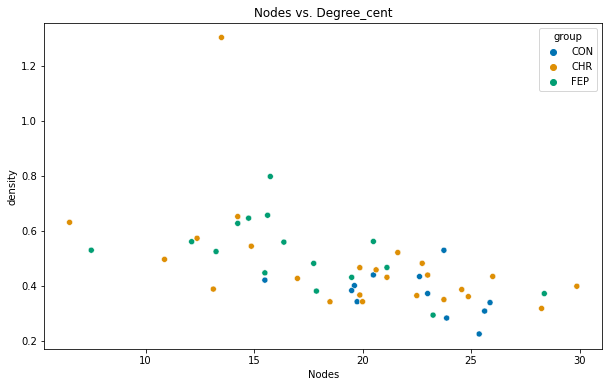

In [90]:

# ----------- Plot nodes vs edges -----------
fig, ax = plt.subplots(figsize=(10, 6))
groups = oasis_avg.group.unique()

sns.scatterplot(data=oasis_avg, x="nodes", y="max_degree_centrality", hue="group", palette='colorblind')

plt.title('Nodes vs. Degree_cent')
plt.xlabel('Nodes')
plt.ylabel('density')
output = op.join(output_figures, 'Nodes_vs_Degree_cent' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)